The XOR dataset
=========

The XOR dataset is a non-linear dataset that is based on the [Exclusive OR](https://en.wikipedia.org/wiki/Exclusive_or) logical operation. Given two inputs and one output, the output is equal to 1 (true) only when the two inputs have the same value (both true or both false):

- 1 XOR 1 = 0
- 1 XOR 0 = 1
- 0 XOR 1 = 1
- 0 XOR 0 = 0

The **XOR affair** was one of the reason that lead to dismiss research on neural networks in the Seventies. Altough there waere multiple factors that influenced this phenomenon, one of the main reason was the publication of the book called [Perceptron](https://en.wikipedia.org/wiki/Perceptrons_(book) by Minsky and Papert in the 1969. In the book was proved that a simple neural network (like the Perceptron invented by [Rosenblat](https://en.wikipedia.org/wiki/Frank_Rosenblatt)) was not able to solve non-linear problems like the XOR classification task. Only in the Eighties it was discovered that using a multi-layer version of the Perceptron it was possible to solve the XOR problem.

Here I will show you how to build the XOR dataset from scratch using Tensorflow and how to store it in a TFRecord file that can be used to train and test our models. The idea is to generate random points in a **Cartesian plane**. We need two input values in order to apply the XOR operator. We can use the X and Y coordinate of the plane to represent those inputs. Each point has an associated label, in our case we represent true with a positive number, and false with a negative number. In this way we have an input tuple of two values and a single output representing the target.

In [28]:
import tensorflow as tf

interval = 10 #the interval used to generate the points
dataset_size = 2500 #elements in each quadrant (total = dataset_size * 4)

#those are the portion of the Cartesian plane having equal-sign coordinates
input_up_right = tf.random_uniform([dataset_size, 2], minval=0, maxval=interval, dtype=tf.float32)
target_up_right = tf.zeros([dataset_size, 1], dtype=tf.float32)
input_down_left = tf.random_uniform([dataset_size, 2], minval=-interval, maxval=0, dtype=tf.float32)
target_down_left = tf.zeros([dataset_size, 1], dtype=tf.float32)

#the up-left quadrant has positive Y and negative X
input_up_left_x = tf.random_uniform([dataset_size, 1], minval=-interval, maxval=0, dtype=tf.float32)
input_up_left_y = tf.random_uniform([dataset_size, 1], minval=0, maxval=interval, dtype=tf.float32)
input_up_left = tf.concat([input_up_left_x, input_up_left_y], axis=1)
target_up_left = tf.ones([dataset_size, 1], dtype=tf.float32)

#the down_right quadrant has positive X and negative Y
input_down_right_x = tf.random_uniform([dataset_size, 1], minval=0, maxval=interval, dtype=tf.float32)
input_down_right_y = tf.random_uniform([dataset_size, 1], minval=-interval, maxval=0, dtype=tf.float32)
input_down_right = tf.concat([input_down_right_x, input_down_right_y], axis=1)
target_down_right = tf.ones([dataset_size, 1], dtype=tf.float32)

#now we can concatenate (vertically) the four quadrants into a dataset
xor_features = tf.concat([input_up_right, input_down_left, input_up_left ,input_down_right], axis=0)
xor_labels = tf.concat([target_up_right, target_down_left, target_up_left, target_down_right], axis=0)

To verify that everything is correct, we can use Matplotlib to plot the dataset as a scatterplot.

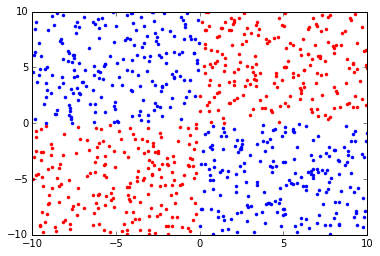

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

#declare an interactive session 
#and convert tensor to numpy arrays
sess = tf.InteractiveSession()
xor_features_np = xor_features.eval()
xor_labels_np = xor_labels.eval()

#We show only a part of the dataset
portion = 200
chunk = dataset_size
interval = chunk*0
plt.plot(xor_features_np[interval:interval+portion,0], xor_features_np[interval:interval+portion,1], 'r.')
interval = chunk*1
plt.plot(xor_features_np[interval:interval+portion,0], xor_features_np[interval:interval+portion,1], 'r.')
interval = chunk*2
plt.plot(xor_features_np[interval:interval+portion,0], xor_features_np[interval:interval+portion,1], 'b.')
interval = chunk*3
plt.plot(xor_features_np[interval:interval+portion,0], xor_features_np[interval:interval+portion,1], 'b.')
plt.show()

Save in TFRecords format
-----------------------------

We can use the numpy arrays in order to store the dataset in a TFRecord file. First of all we have to create a function that is able to convert the array in a serial file. Then we can use the function on our dataset and store the files on disk. I will split the dataset in test and training set. The test set is 1/5 of the total dataset. 

In [30]:
def numpy_to_tfrecord(features_array, labels_array, output_file):
    with tf.python_io.TFRecordWriter(output_file) as record_writer:
        for i in range(labels_array.shape[0]):
            #Getting the data as train feature 
            float_feature = tf.train.Feature(float_list=tf.train.FloatList(value=features_array[i].tolist()))
            int64_feature = tf.train.Feature(int64_list=tf.train.Int64List(value=[labels_array[i]]))
            #Stuff the data in an Example buffer
            example = tf.train.Example(features=tf.train.Features(feature={'feature': float_feature,
                                                                           'label': int64_feature}))
            #Serialize example to string and write in tfrecords
            record_writer.write(example.SerializeToString())

In [31]:
import numpy as np

#merging for shuffling
xor_merged = np.concatenate([xor_features_np, xor_labels_np], axis=1)
print("Checking shuffle consistency...")
print(xor_merged[10]) #printing a random value before shuffle
np.random.shuffle(xor_merged)
print(xor_merged[10]) #printing the same value after shuffle
print("")
#unmerging after shuffling
xor_features_np = xor_merged[:,0:2]
xor_labels_np = xor_merged[:,2:]

#splitting in training and test set
to_take =  xor_features_np.shape[0] - (xor_features_np.shape[0] / 5)
xor_features_train = xor_features_np[0:to_take,:]
xor_labels_train = xor_labels_np[0:to_take,:]
xor_features_test = xor_features_np[to_take:,:]
xor_labels_test = xor_labels_np[to_take:,:]

print("Train features: " + str(xor_features_train.shape))
print("Train labels: " + str(xor_labels_train.shape))
#random_indeces = [200, 2845, 5009, 7985]
#print(xor_features_train[random_indeces])
#print(xor_labels_train[random_indeces])
print("")
print("Test features: " + str(xor_features_test.shape))
print("Test labels: " + str(xor_labels_test.shape))

Checking shuffle consistency...
[3.3309567 4.308746  0.       ]
[ 4.6031237 -4.9967775  1.       ]

Train features: (8000, 2)
Train labels: (8000, 1)

Test features: (2000, 2)
Test labels: (2000, 1)


In [32]:
numpy_to_tfrecord(xor_features_train, xor_labels_train, "./xor_train.tfrecord")

In [33]:
numpy_to_tfrecord(xor_features_test, xor_labels_test, "./xor_test.tfrecord")

Conclusions
-------------

The TFRecord files of the XOR dataset can be easily used in a Tensorflow model. The features are represented as a list of floats whereas the label is a value that can be zero or one.

**Copyright (c)** 2018 Massimiliano Patacchiola, MIT License